In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# read data

In [2]:
#### string gene_id map
local_stringdb = os.path.join('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb','2023')

ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.info.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
ppidf['preferred_name'] = ppidf['preferred_name'].str.upper()
stringId2name = ppidf.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = ppidf.set_index('preferred_name')['#string_protein_id'].to_dict()
ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.aliases.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
ppidf['alias'] = ppidf['alias'].str.upper()
aliases2stringId = ppidf.set_index('alias')['#string_protein_id'].to_dict()

In [3]:
ppi_features = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/ppi_full_emb.csv')

all_df = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/disgenet_string.csv')

## multiple diseases

In [4]:
def read_data(disease, dga, features):
    pos_genes_list = dga[dga['disease_id']==disease]['string_id']
    df = features
    df['label'] = df['string_id'].isin(pos_genes_list).astype(int)

    X = df.loc[:, df.columns.str.startswith("feature_")].to_numpy()
    y = df['label'].to_numpy()
    return df, X, y

In [29]:
# disease = 'ICD10_K25'
# disease = 'ICD10_C50'
# disease = 'ICD10_K51'
disease = 'ICD10_E66'
# disease = 'ICD10_G24'

df, X,y = read_data(disease,all_df,ppi_features)


In [30]:
np.sum(y==1)

284

# clustering

In [21]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import umap
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2,random_state=2023)
umap_result = umap_model.fit_transform(X)

/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


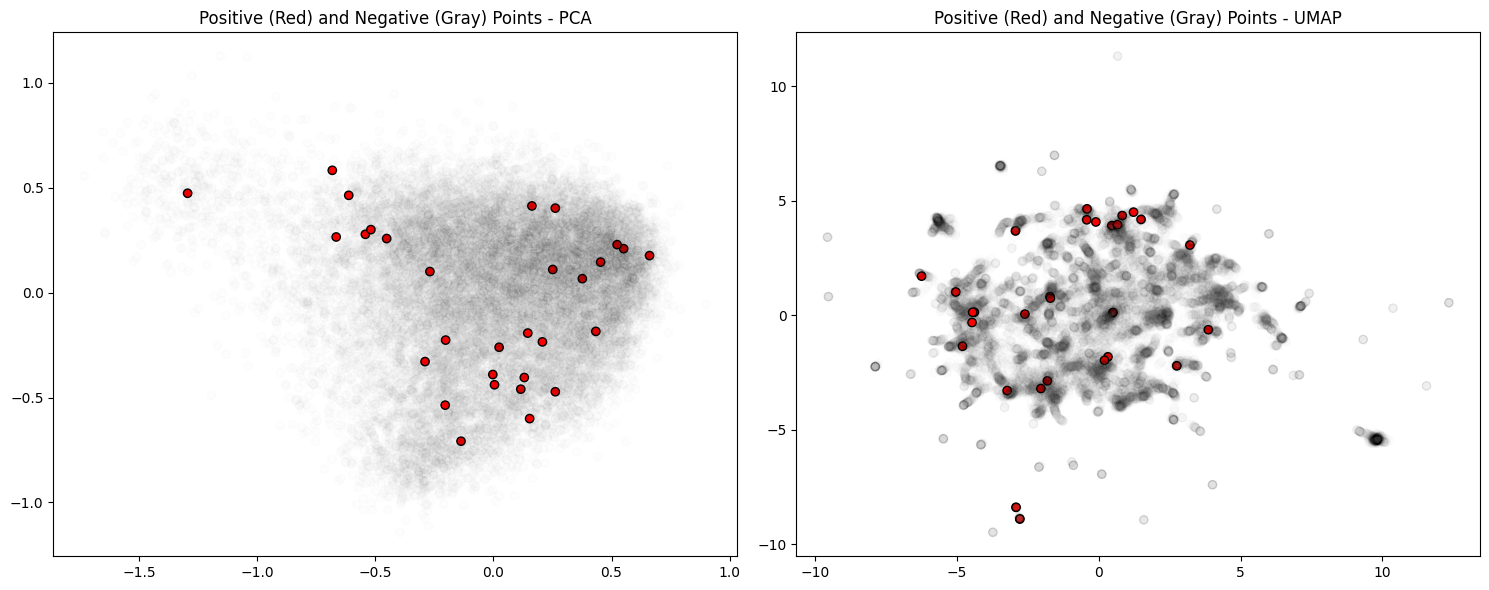

In [28]:


# Create color mapping for first plot
colors_binary = np.where(y == 1, 'red', 'gray')
alphas_binary = np.where(y == 1, 1.0, 0.01)  # Highlight y=1, others transparent

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot without clusters
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors_binary, alpha=alphas_binary, edgecolors='k')
axes[0].set_title("Positive (Red) and Negative (Gray) Points - PCA")

# Plot without clusters
axes[1].scatter(umap_result[:, 0], umap_result[:, 1], c=colors_binary, alpha=alphas_binary, edgecolors='k')
axes[1].set_title("Positive (Red) and Negative (Gray) Points - UMAP")


plt.tight_layout()
plt.show()

## k means

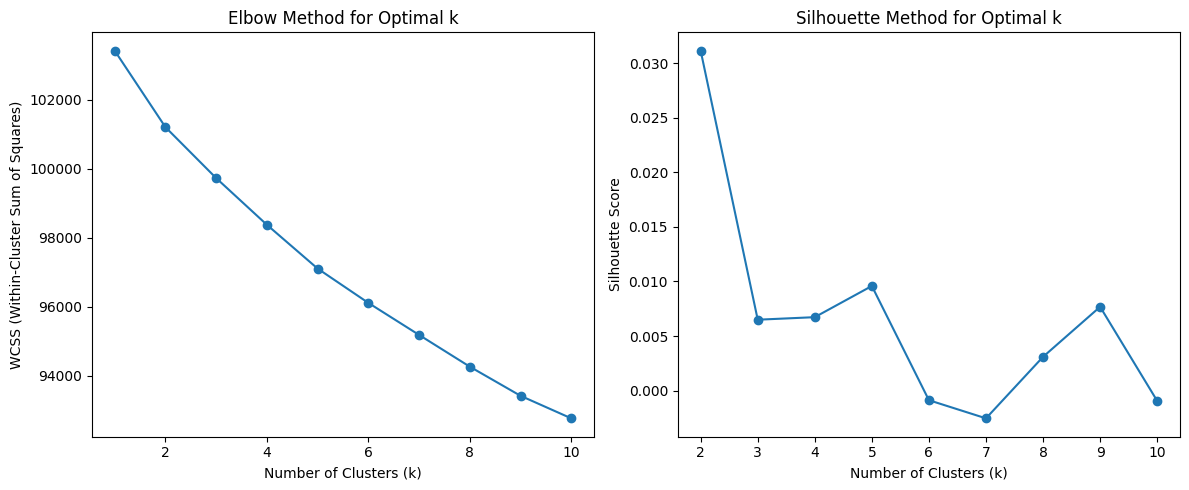

In [ ]:
# # Try different values of k
# wcss = []
# K_range = range(1, 11)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)  # Sum of squared distances to cluster center

# silhouette_scores = []

# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(X)
#     score = silhouette_score(X, labels)
#     silhouette_scores.append(score)

# # Plot Elbow Method and Silhouette Scores side by side
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Elbow Method plot
# axes[0].plot(K_range, wcss, marker='o', linestyle='-')
# axes[0].set_xlabel("Number of Clusters (k)")
# axes[0].set_ylabel("WCSS (Within-Cluster Sum of Squares)")
# axes[0].set_title("Elbow Method for Optimal k")

# # Silhouette Score plot
# axes[1].plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
# axes[1].set_xlabel("Number of Clusters (k)")
# axes[1].set_ylabel("Silhouette Score")
# axes[1].set_title("Silhouette Method for Optimal k")

# plt.tight_layout()
# plt.show()

In [24]:
cluster_on = 'umap'

silhouette_scores = []
calinski_scores = []
DBI_scores = []

range_list = range(3, 11)
# range_list = [6,10,20,50,100,150,200]

for k in range_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    if cluster_on == 'pos':
        X_pos = X[np.where(y == 1)]
        labels = kmeans.fit_predict(X_pos)
        kmeans_labels_pos = labels

        silhouette_scores.append(silhouette_score(X_pos, kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(X_pos, kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(X_pos, kmeans_labels_pos))
    elif cluster_on == 'all':
        labels = kmeans.fit_predict(X)
        kmeans_labels_pos = labels[np.where(y == 1)]
        silhouette_scores.append(silhouette_score(X_pos, kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(X_pos, kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(X_pos, kmeans_labels_pos))
    elif cluster_on == 'umap':
        labels = kmeans.fit_predict(umap_result)
        kmeans_labels_pos = labels[np.where(y == 1)]     

        silhouette_scores.append(silhouette_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(umap_result[np.where(y == 1)], kmeans_labels_pos))   
    elif cluster_on == 'umap_pos':
        labels = kmeans.fit_predict(umap_result[np.where(y == 1)])
        kmeans_labels_pos = labels  

        silhouette_scores.append(silhouette_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(umap_result[np.where(y == 1)], kmeans_labels_pos)) 



# Find the maximum silhouette score and its corresponding k
max_silhouette_score = max(silhouette_scores)
optimal_k_silhouette = range_list[silhouette_scores.index(max_silhouette_score)]

# Find the minimum Davies-Bouldin score and its corresponding k
min_dbi_score = min(DBI_scores)
optimal_k_dbi = range_list[DBI_scores.index(min_dbi_score)]

# Find the maximum Calinski-Harabasz score and its corresponding k
max_calinski_score = max(calinski_scores)
optimal_k_calinski = range_list[calinski_scores.index(max_calinski_score)]

print(round(max_silhouette_score,3),round(min_dbi_score,3),round(max_calinski_score,3))




0.533 0.588 315.675


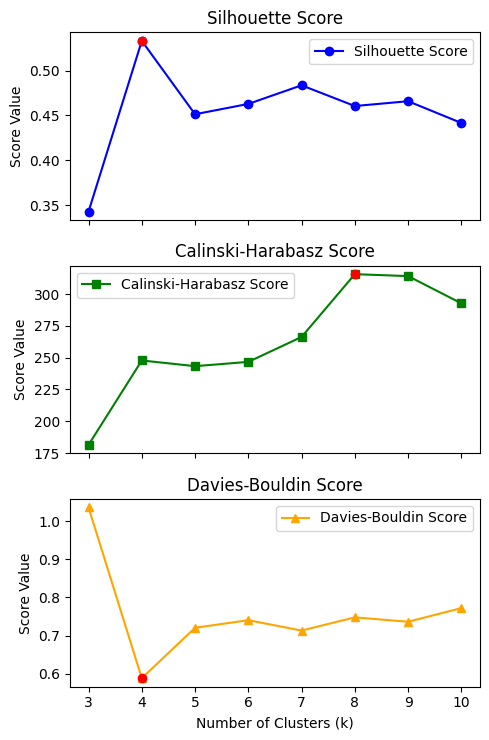

In [25]:
import matplotlib.pyplot as plt

# Create a 3x1 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 7.5), sharex=True)

# Plot Silhouette Score
axes[0].plot(range_list, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
axes[0].scatter(optimal_k_silhouette, max_silhouette_score, color='r', zorder=5)
axes[0].set_title('Silhouette Score')
axes[0].set_ylabel('Score Value')
axes[0].legend()

# Plot Calinski-Harabasz Score
axes[1].plot(range_list, calinski_scores, marker='s', linestyle='-', color='g', label='Calinski-Harabasz Score')
axes[1].scatter(optimal_k_calinski, max_calinski_score, color='r', zorder=5)
axes[1].set_title('Calinski-Harabasz Score')
axes[1].set_ylabel('Score Value')
axes[1].legend()

# Plot Davies-Bouldin Score
axes[2].plot(range_list, DBI_scores, marker='^', linestyle='-', color='orange', label='Davies-Bouldin Score')
axes[2].scatter(optimal_k_dbi, min_dbi_score, color='r', zorder=5)
axes[2].set_title('Davies-Bouldin Score')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Score Value')
axes[2].legend()

# Set a common x-axis label
fig.tight_layout()
plt.show()


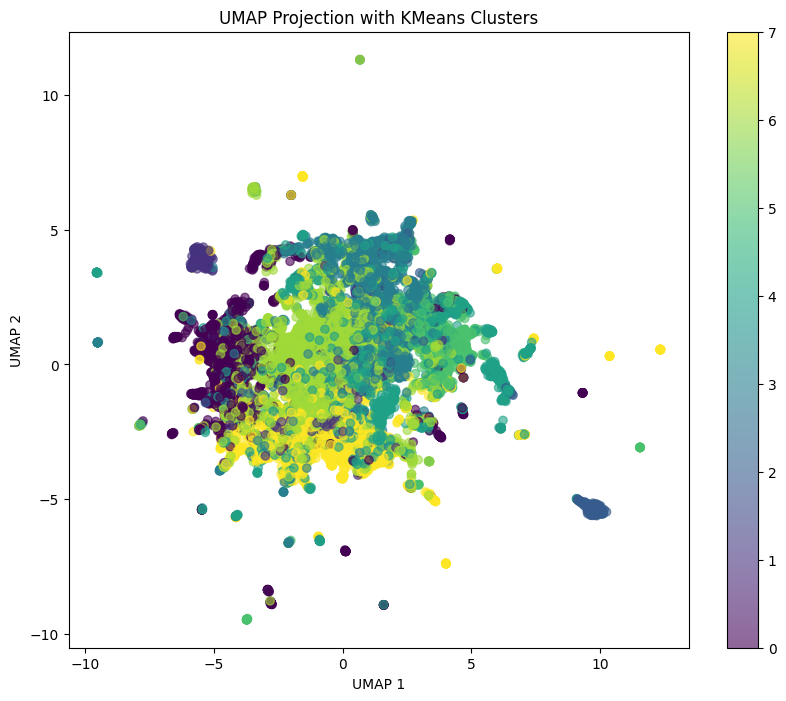

In [40]:
# Plotting
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)

# labels = kmeans.fit_predict(umap_result)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis', alpha=0.6)

# Add a color bar to show which color corresponds to which cluster
plt.colorbar(scatter, ticks=np.arange(np.min(labels), np.max(labels) + 1))

# Add labels and title
plt.title('UMAP Projection with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show plot
plt.show()

In [37]:
# Apply Hierarchical Clustering

from scipy.cluster.hierarchy import fcluster

def getLinkageMat(model):
    children = model.children_
    cs = np.zeros(len(children))
    N = len(model.labels_)
    for i,child in enumerate(children):
        count = 0
        for idx in child:
            count += 1 if idx < N else cs[idx - N]
        cs[i] = count
    return np.column_stack([children, model.distances_, cs])


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

cluster_on = 'all'

if cluster_on == 'all':
    model = model.fit(X)
    mat = getLinkageMat(model)
elif cluster_on == 'umap':
    model = model.fit(umap_result)
    mat = getLinkageMat(model)


0.033 2.945 6.659


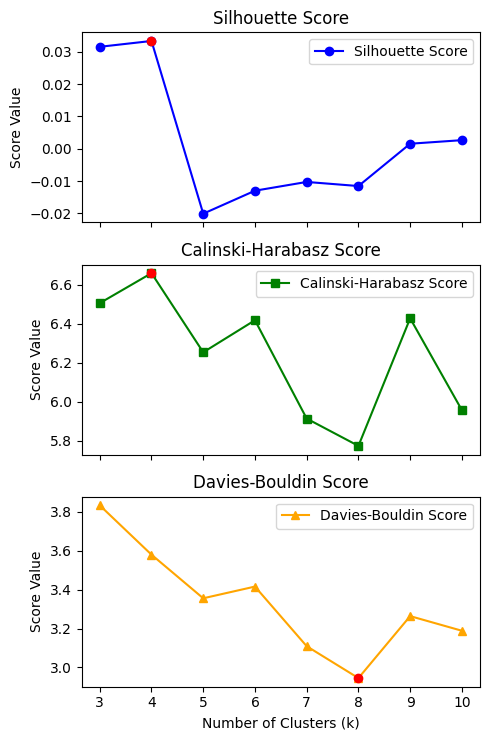

In [38]:

silhouette_scores = []
calinski_scores = []
DBI_scores = []

range_list = range(3,11)
# range_list = [6,10,20,50,100,150,200]

for n_clusters in range_list:
    labels = fcluster(mat, n_clusters, criterion='maxclust')

    if cluster_on == 'all':
        X_pos = X[np.where(y == 1)]
        kmeans_labels_pos = labels[np.where(y == 1)]

        silhouette_scores.append(silhouette_score(X_pos, kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(X_pos, kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(X_pos, kmeans_labels_pos))
    elif cluster_on == 'umap':
        kmeans_labels_pos = labels[np.where(y == 1)]     

        silhouette_scores.append(silhouette_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        calinski_scores.append(calinski_harabasz_score(umap_result[np.where(y == 1)], kmeans_labels_pos))
        DBI_scores.append(davies_bouldin_score(umap_result[np.where(y == 1)], kmeans_labels_pos))         

# Find the maximum silhouette score and its corresponding k
max_silhouette_score = max(silhouette_scores)
optimal_k_silhouette = range_list[silhouette_scores.index(max_silhouette_score)]

# Find the minimum Davies-Bouldin score and its corresponding k
min_dbi_score = min(DBI_scores)
optimal_k_dbi = range_list[DBI_scores.index(min_dbi_score)]

# Find the maximum Calinski-Harabasz score and its corresponding k
max_calinski_score = max(calinski_scores)
optimal_k_calinski = range_list[calinski_scores.index(max_calinski_score)]

print(round(max_silhouette_score,3),round(min_dbi_score,3),round(max_calinski_score,3))

# Create a 3x1 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 7.5), sharex=True)

# Plot Silhouette Score
axes[0].plot(range_list, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
axes[0].scatter(optimal_k_silhouette, max_silhouette_score, color='r', zorder=5)
axes[0].set_title('Silhouette Score')
axes[0].set_ylabel('Score Value')
axes[0].legend()

# Plot Calinski-Harabasz Score
axes[1].plot(range_list, calinski_scores, marker='s', linestyle='-', color='g', label='Calinski-Harabasz Score')
axes[1].scatter(optimal_k_calinski, max_calinski_score, color='r', zorder=5)
axes[1].set_title('Calinski-Harabasz Score')
axes[1].set_ylabel('Score Value')
axes[1].legend()

# Plot Davies-Bouldin Score
axes[2].plot(range_list, DBI_scores, marker='^', linestyle='-', color='orange', label='Davies-Bouldin Score')
axes[2].scatter(optimal_k_dbi, min_dbi_score, color='r', zorder=5)
axes[2].set_title('Davies-Bouldin Score')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Score Value')
axes[2].legend()

# Set a common x-axis label
fig.tight_layout()
plt.show()


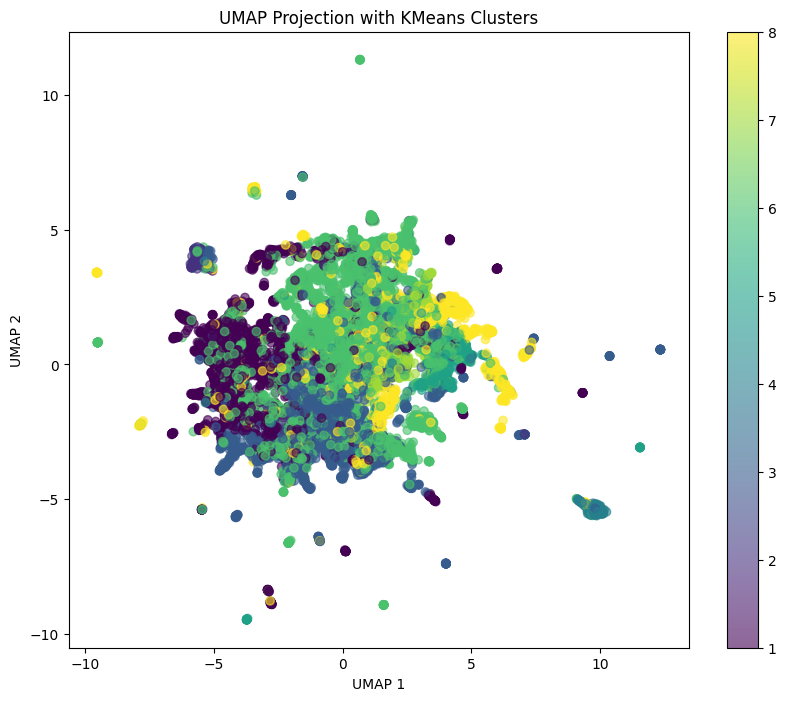

In [ ]:
labels = fcluster(mat, 8, criterion='maxclust')

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis', alpha=0.6)

# Add a color bar to show which color corresponds to which cluster
plt.colorbar(scatter, ticks=np.arange(np.min(labels), np.max(labels) + 1))

# Add labels and title
plt.title('UMAP Projection with hierarchical Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Show plot
plt.show()

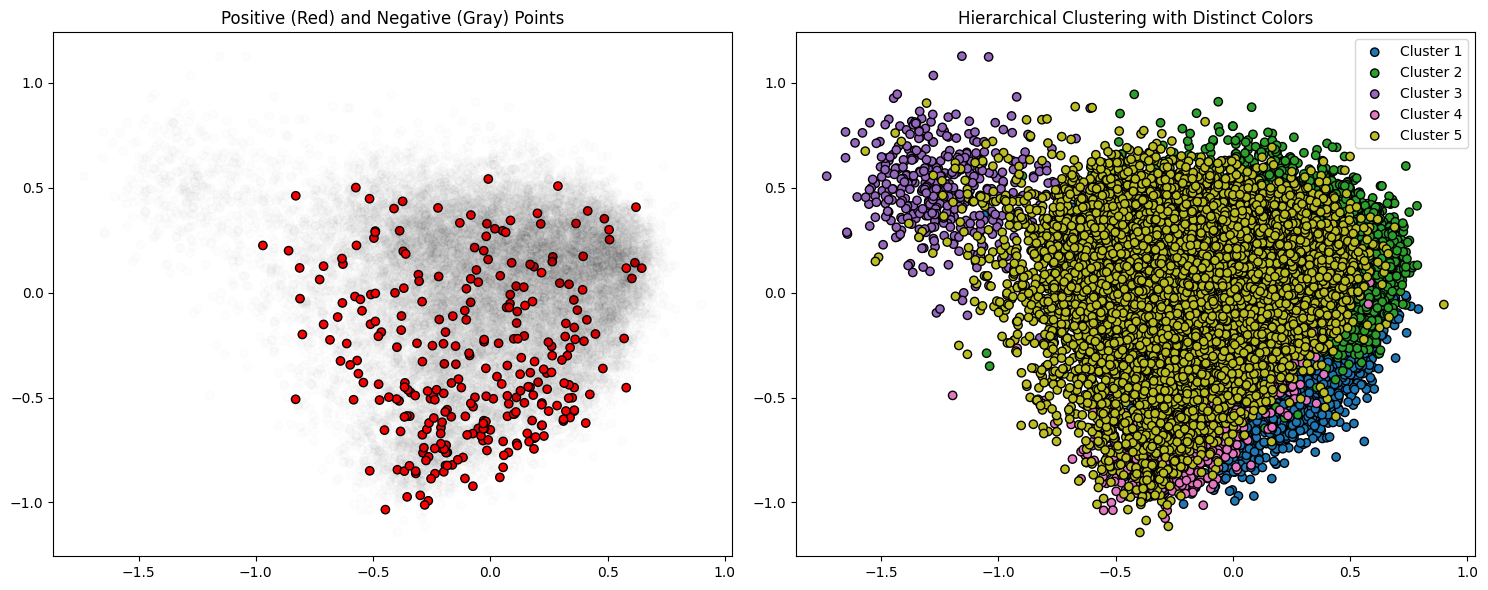

In [42]:
# threshold = np.max(mat[:, 2])*0.7
# hierachi_labels = fcluster(mat, threshold, criterion='distance')
n_clusters = 5
hierachi_labels = fcluster(mat, n_clusters, criterion='maxclust')


# Get unique clusters
unique_clusters = np.unique(hierachi_labels)

# Generate distinct colors, avoiding white
num_clusters = len(unique_clusters)
cmap = plt.colormaps.get_cmap('tab10')  # Corrected function call

# Create a mapping from cluster to color
cluster_color_map = {cluster: cmap(i / num_clusters) for i, cluster in enumerate(unique_clusters)}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot without clusters
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors_binary, alpha=alphas_binary, edgecolors='k')
axes[0].set_title("Positive (Red) and Negative (Gray) Points")

# Plot with clusters, ensuring color assignment
for cluster in unique_clusters:
    mask = hierachi_labels == cluster
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    color=[cluster_color_map[cluster]] * np.sum(mask),  # Ensures consistent color
                    edgecolors='k', label=f'Cluster {cluster}')

axes[1].legend()
axes[1].set_title("Hierarchical Clustering with Distinct Colors")

plt.tight_layout()
plt.show()

In [44]:
random_distribution = np.sum(y == 1) / len(y)
print(f"Random distribution of positive for each cluster should be: {random_distribution * 100:.2f}%")
def show_pos_proportion(labels):
    unique_clusters = np.unique(labels)
    for c in unique_clusters:
        cluster_indices = np.where(labels == c)[0]
        num_y1 = np.sum(y[cluster_indices] == 1)
        percentage_y1 = (num_y1 / len(cluster_indices)) * 100
        print(f"Cluster {c} (size {len(cluster_indices)}): {num_y1} instances of positive samples ({percentage_y1:.2f}%)")

show_pos_proportion(labels)
print('\n')

Random distribution of positive for each cluster should be: 1.45%
Cluster 0 (size 2872): 102 instances of positive samples (3.55%)
Cluster 1 (size 659): 3 instances of positive samples (0.46%)
Cluster 2 (size 507): 2 instances of positive samples (0.39%)
Cluster 3 (size 3500): 70 instances of positive samples (2.00%)
Cluster 4 (size 1844): 1 instances of positive samples (0.05%)
Cluster 5 (size 1923): 52 instances of positive samples (2.70%)
Cluster 6 (size 4382): 28 instances of positive samples (0.64%)
Cluster 7 (size 3935): 26 instances of positive samples (0.66%)




# svm

In [31]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import KFold, GridSearchCV
from rdkit.ML.Scoring.Scoring import CalcBEDROC
# from pseudo_label import select_pseudo_negatives
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage



In [32]:
##### CV
def select_parameter(X_train,y_train):
        # Define parameter grid
    param_grid = {
        'C': [0.1, 0.5, 0.8, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto',0.1,1,10,100]
    }

    # Initialize SVM with probability estimates
    clf = svm.SVC(probability=True)
    # Perform Grid Search with Cross-Validation using AUC as the scoring metric
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', verbose=1)
    grid_search.fit(X_train,y_train)
    return grid_search.best_params_
    # print("Best cross-validation AUC:", grid_search.best_score_)

In [33]:
##### metrics
def average_rank_ratio(y_scores, y_test):
    """
    Calculate the average predicted rank of true positives.

    Parameters:
    y_scores (array-like): Decision function scores from the classifier.
    y_test (array-like): True binary labels (0 for negative, 1 for positive).

    Returns:
    float: The average rank of true positives.
    """
    
    # Convert inputs to numpy arrays for consistency
    y_scores = np.array(y_scores)
    y_test = np.array(y_test)

    # Step 1: Sort scores in descending order and assign ranks
    sorted_indices = np.argsort(-y_scores)  # Negative for descending sort
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(y_scores) + 1)  # Rank starts from 1

    # Step 2: Identify true positives
    true_positive_indices = np.where(y_test == 1)[0]

    # Step 3: Extract ranks of true positives
    true_positive_ranks = ranks[true_positive_indices]

    # Step 4: Calculate the average rank of true positives
    average_rank = np.mean(true_positive_ranks)

    rank_ratio = average_rank/y_test.shape[0]

    return round(rank_ratio,4)

def top_recall_precision(frac,y_scores,y_test):
    if np.sum(y_test==1) == 0:
        return 0,0,0
    else:
        cut = int(len(y_scores)*frac)
        top_30_indices = np.argsort(y_scores)[-cut:][::-1]
        top_30_y_scores = y_scores[top_30_indices]
        top_30_y_test = y_test[top_30_indices]

        TP = np.sum(top_30_y_test == 1)

        recall = TP/np.sum(y_test==1)
        precision = TP/len(top_30_indices)
        max_precision = np.sum(y_test==1)/len(top_30_indices)

    return recall, precision, max_precision



def eval(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    if hasattr(clf, "decision_function"):
        y_scores = clf.decision_function(X_test)
    else:
        y_scores = None  # AUROC cannot be computed without scores

    rank_ratio = average_rank_ratio(y_scores, y_test)
    
    if -1 in y_test:
        y_test = np.where(y_test == -1, 0, y_test)
    if -1 in y_pred:
        y_pred = np.where(y_pred == -1, 0, y_pred)
        
    ############### AUCROC
    if y_scores is not None:
        try:
            auroc = roc_auc_score(y_test, y_scores)
        except:
            auroc = "AUROC computation failed (possibly due to label issues)"
    else:
        auroc = "AUROC not available (no predict_proba or decision_function)"


    ############### BEDROC
    scores = np.column_stack((y_test, y_scores))  # Stack labels and scores as columns
    scores = scores[scores[:, 1].argsort()[::-1]]  # Sort by scores in descending order
    ############# top recall
    top_recall_10, top_precision_10, max_precision_10 = top_recall_precision(0.1,y_scores,y_test)
    top_recall_30, top_precision_30, max_precision_30 = top_recall_precision(0.3,y_scores,y_test)
    return (
        recall_score(y_test, y_pred, average="binary", pos_label=1), 
        precision_score(y_test, y_pred, average="binary", pos_label=1), 
        # f1_score(y_test, y_pred, average="binary", pos_label=1),
        top_recall_10, top_precision_10, max_precision_10,
        top_recall_30, top_precision_30, max_precision_30,
        auroc,
        rank_ratio,
        CalcBEDROC(scores, col=0, alpha=160.9),
        CalcBEDROC(scores, col=0, alpha=32.2),
        CalcBEDROC(scores, col=0, alpha=16.1),
        CalcBEDROC(scores, col=0, alpha=5.3)
    )

In [34]:
##### model

def build_normalized_linear_kernel():
    """
    Returns a function that computes a normalized linear kernel (cosine similarity).
    The scaling factor C is optional and can adjust the magnitude of the kernel.
    """
    def normalized_linear_kernel(X, Y):
        # Step 1: Manually compute the linear kernel (dot product)
        K = np.dot(X, Y.T)
        
        # Step 2: Compute norms of X and Y for normalization
        X_norms = np.linalg.norm(X, axis=1)
        Y_norms = np.linalg.norm(Y, axis=1)
        
        # Avoid division by zero
        X_norms[X_norms == 0] = 1e-10
        Y_norms[Y_norms == 0] = 1e-10
        
        # Normalize the kernel (cosine similarity)
        normalization_matrix = np.outer(X_norms, Y_norms)
        K_normalized = K / normalization_matrix
        
        return K_normalized
    
    return normalized_linear_kernel



def build_normalized_poly_kernel(coef0=1.0, degree=2):
    """
    Returns a function that computes a normalized polynomial kernel with dynamic parameters.
    
    Parameters:
    - coef0: Independent term added to the dot product (default=1.0).
    - degree: Degree of the polynomial kernel (default=2).
    """
    def custom_poly_kernel(X, Y):
        # Step 1: Compute the polynomial kernel
        K = (np.dot(X, Y.T) + coef0) ** degree
        
        # Step 2: Compute self-similarities (for normalization)
        K_self_X = (np.sum(X * X, axis=1) + coef0) ** degree  # Diagonal for X
        K_self_Y = (np.sum(Y * Y, axis=1) + coef0) ** degree  # Diagonal for Y
        
        # Step 3: Avoid division by zero (replace zeros with a small number)
        K_self_X[K_self_X == 0] = 1e-10
        K_self_Y[K_self_Y == 0] = 1e-10
        
        # Step 4: Normalize the kernel
        normalization_matrix = np.outer(np.sqrt(K_self_X), np.sqrt(K_self_Y))
        K_normalized = K / normalization_matrix
        
        return K_normalized
    
    return custom_poly_kernel

In [35]:
##### pseudo label

def calculate_proportion(hierarchical_labels, y_train, func):
    proportion = []
    unique_clusters = np.unique(hierarchical_labels)
    
    # Total number of samples with label 1
    total_y1 = np.sum(y_train == 1)
    if total_y1 == 0:
        raise ValueError("No positive samples in training data")

    for c in unique_clusters:
        cluster_indices = np.where(hierarchical_labels == c)[0]
        cluster_y1 = np.sum(y_train[cluster_indices] == 1)
        
        if func == 1:
            A_i = len(cluster_indices) * (1 - (cluster_y1 / total_y1))
        elif func == 2:
            A_i = max(0, 2 * len(cluster_indices) / len(y_train) - (cluster_y1 / total_y1))
        elif func == 3:
            A_i = max(0, 2 * len(cluster_indices) / len(y_train) - (cluster_y1 / total_y1))
            if cluster_y1 == 0:
                # A_i = np.exp(0.05 * A_i)
                A_i = A_i**0.5
        
        proportion.append(A_i)
    
    return proportion

def cluster_negative_sampling(hierarchical_labels, y_train, proportion, neg_size):
    neg_cluster = []
    all_sampled_negatives = []
    unique_clusters = np.unique(hierarchical_labels)
    total_proportion = sum(proportion)

    if total_proportion == 0:
        raise ValueError("Sum of proportions is zero. Check the 'proportion' calculation.")

    for index, c in enumerate(unique_clusters):
        A_i = proportion[index]
        neg_i = int((A_i / total_proportion) * neg_size)

        cluster_indices = np.where(hierarchical_labels == c)[0]
        negative_indices = cluster_indices[y_train[cluster_indices] == 0]

        if len(negative_indices) == 0:
            continue  
        neg_i = min(neg_i, len(negative_indices))  # Adjust to max available

        sampled_indices = np.random.choice(negative_indices, size=neg_i, replace=False)
        all_sampled_negatives.extend(sampled_indices)
        neg_cluster.append(neg_i)

    return all_sampled_negatives


In [36]:
def select_pseudo_negatives(neg_num, X_train_pos, y_train_pos, X_all_neg, y_all_neg, func):
    # Combine positive and negative samples
    X_train = np.vstack((X_train_pos, X_all_neg))
    y_train = np.hstack((y_train_pos, y_all_neg))

    # Hierarchical clustering
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True)
    model.fit(X_train)

    # Get linkage matrix
    mat = linkage(X_train, method='ward')

    # Get first-level labels
    n_clusters = 8
    hierarchical_labels = fcluster(mat, n_clusters, criterion='maxclust')

    # Sample negatives
    proportion = calculate_proportion(hierarchical_labels, y_train, func)
    all_sampled_negatives = cluster_negative_sampling(hierarchical_labels, y_train, proportion, neg_num)

    return all_sampled_negatives, X_train[all_sampled_negatives], y_train[all_sampled_negatives]

In [37]:
def select_pseudo_negatives(neg_num, X_train_pos, y_train_pos, X_all_neg, y_all_neg, func,umap,cluster_method,n_clusters):
    # Combine positive and negative samples
    X_train = np.vstack((X_train_pos, X_all_neg))
    y_train = np.hstack((y_train_pos, y_all_neg))

    
    if cluster_method == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        if umap:
            X_train_umap = umap_model.fit_transform(X_train)
            hierarchical_labels = kmeans.fit_predict(X_train_umap)
        else:
            hierarchical_labels = kmeans.fit_predict(X_train)
    elif cluster_method == 'hierarchical':
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, compute_distances=True)
        if umap:
            X_train_umap = umap_model.fit_transform(X_train)
            # Hierarchical clustering
            model.fit(X_train_umap)
            # Get linkage matrix
            mat = linkage(X_train_umap, method='ward')
        else:
            model.fit(X_train)
            # Get linkage matrix
            mat = linkage(X_train, method='ward')

        # Get first-level labels
        n_clusters = n_clusters
        hierarchical_labels = fcluster(mat, n_clusters, criterion='maxclust')

    # Sample negatives
    proportion = calculate_proportion(hierarchical_labels, y_train, func)
    all_sampled_negatives = cluster_negative_sampling(hierarchical_labels, y_train, proportion, neg_num)

    return all_sampled_negatives, X_train[all_sampled_negatives], y_train[all_sampled_negatives]

In [ ]:
# train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# X_train = X[df.index.get_indexer(train_idx)]
# y_train = y[df.index.get_indexer(train_idx)]

# X_test = X[df.index.get_indexer(test_idx)]
# y_test = y[df.index.get_indexer(test_idx)]

# print(X_train.shape, np.sum(y_train == 1))
# print(X_test.shape, np.sum(y_test == 1))

(15697, 128) 105
(3925, 128) 41


## ooc svm

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(df)):
    X_train = X[df.index.get_indexer(train_idx)]
    y_train = y[df.index.get_indexer(train_idx)]

    X_test = X[df.index.get_indexer(test_idx)]
    y_test = y[df.index.get_indexer(test_idx)]

In [11]:


X_pos_train = X_train[np.where(y_train == 1)]
y_pos_train = y_train[np.where(y_train == 1)]
y_test_ooc = np.where(y_test == 0, -1, y_test)

In [18]:
clf = svm.OneClassSVM(nu=0.8,kernel=build_normalized_linear_kernel())
["ooc_svm","norm_linear", *eval(clf, X_pos_train, y_pos_train, X_test, y_test_ooc)]

['ooc_svm',
 'norm_linear',
 0.9908256880733946,
 0.9908256880733946,
 0.988045238039372,
 0.9893048631140008,
 0.8778050748019948,
 0.125]

In [ ]:
clf = svm.OneClassSVM(nu=0.8,kernel=build_normalized_linear_kernel())
["ooc_svm","norm_linear", *eval(clf, X_pos_train, y_pos_train, X_test, y_test_ooc)]

['ooc_svm',
 'norm_linear',
 0.9908256880733946,
 0.9908256880733946,
 0.988045238039372,
 0.9893048631140008,
 0.8778050748019948,
 0.125]

In [ ]:
clf = svm.OneClassSVM(nu= 0.8, kernel=build_normalized_poly_kernel(degree = 3))
result_df.loc[len(result_df.index)] = ["ooc_svm","norm_poly", *eval(clf, X_pos_train, y_pos_train, X_test, y_test_ooc)]

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3884
           1       0.23      0.24      0.24        41

    accuracy                           0.98      3925
   macro avg       0.61      0.62      0.61      3925
weighted avg       0.98      0.98      0.98      3925


    Accuracy: 0.9836942675159236
    Recall: 0.9836942675159236
    Precision: 0.9840812516107104
    F1-score: 0.9838862837480689
    AUROC: 0.8882406872472433
    Rank ratio: 11.59%
    
Confusion Matrix:
[[3851   33]
 [  31   10]]


In [40]:
clf = svm.OneClassSVM(nu= 0.8, kernel='rbf')
eval(clf, X_pos_train, y_pos_train, X_test, y_test_ooc,print_result=True)
# result_df.loc[len(result_df.index)] = ["ooc_svm","rbf", *eval(clf, X_pos_train, y_pos_train, X_test, y_test_ooc)]

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3884
           1       0.17      0.29      0.22        41

    accuracy                           0.98      3925
   macro avg       0.58      0.64      0.60      3925
weighted avg       0.98      0.98      0.98      3925


        Accuracy: 0.9780891719745223
        Recall: 0.9780891719745223
        Precision: 0.9839286251897441
        F1-score: 0.980838190825452
        AUROC: 0.8819170580995203
        Rank ratio: 12.22%
        
Confusion Matrix:
[[3827   57]
 [  29   12]]


(0.9780891719745223,
 0.9780891719745223,
 0.9839286251897441,
 0.980838190825452,
 0.8819170580995203,
 0.1222)

## rabdom negative

In [61]:
negative_indices = np.where(y_train == 0)[0]
positive_indices = np.where(y_train == 1)[0]

# Randomly select the same number of negative samples as positive samples
random_neg_indices = np.random.choice(negative_indices, size=5*len(positive_indices), replace=False)

# Combine positive and selected negative samples
balanced_indices = np.concatenate([positive_indices, random_neg_indices])
# Extract the balanced subset
X_train_balance = X_train[balanced_indices]
y_train_balance = y_train[balanced_indices] 

In [28]:
clf = SVC(C=0.8,kernel=build_normalized_linear_kernel())

result_df.loc[len(result_df.index)] = ["random_svm","norm_linear", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3884
           1       0.06      0.85      0.10        41

    accuracy                           0.85      3925
   macro avg       0.53      0.85      0.51      3925
weighted avg       0.99      0.85      0.91      3925


    Accuracy: 0.845859872611465
    Recall: 0.845859872611465
    Precision: 0.9883266946712225
    F1-score: 0.9071976577211935
    AUROC: 0.9148036974705483
    
Confusion Matrix:
[[3285  599]
 [   6   35]]


In [62]:
# clf = SVC(C=0.8,kernel=build_normalized_poly_kernel())
clf = SVC(C=0.8,kernel=build_normalized_poly_kernel(gamma=0.8,degree = 3))

result_df.loc[len(result_df.index)] = ["random_svm","norm_poly", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3884
           1       0.29      0.54      0.38        41

    accuracy                           0.98      3925
   macro avg       0.64      0.76      0.68      3925
weighted avg       0.99      0.98      0.98      3925


    Accuracy: 0.9814012738853504
    Recall: 0.9814012738853504
    Precision: 0.9876931589564385
    F1-score: 0.9841410451802673
    AUROC: 0.9320853532943157
    
Confusion Matrix:
[[3830   54]
 [  19   22]]


In [37]:
clf = SVC(C=0.8,kernel='rbf')
result_df.loc[len(result_df.index)] = ["random_svm","rbf", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       1.00      0.86      0.93      3884
           1       0.06      0.88      0.12        41

    accuracy                           0.86      3925
   macro avg       0.53      0.87      0.52      3925
weighted avg       0.99      0.86      0.92      3925


    Accuracy: 0.8642038216560509
    Recall: 0.8642038216560509
    Precision: 0.9887487844655453
    F1-score: 0.9179977866542656
    AUROC: 0.9227160834945116
    
Confusion Matrix:
[[3356  528]
 [   5   36]]


## pesudo labeling

In [39]:
result_df = pd.DataFrame(columns=['method','umap','func',"fold","para", "recall", "precision", 'top_recall_10', 'top_precision_10', 'max_precision_10','top_recall_30', 'top_precision_30', 'max_precision_30','auroc',"rank_ratio",'bedroc_1','bedroc_5','bedroc_10','bedroc_30'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Get the positive class samples
X_pos = X[y == 1]
y_pos = y[y == 1]


# Loop through each fold
# X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X[y == 1], y[y == 1], test_size=0.2, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(X_pos)):
    X_train_pos, X_test_pos = X_pos[train_idx], X_pos[test_idx]
    y_train_pos, y_test_pos = y_pos[train_idx], y_pos[test_idx]

    neg_num = 5*X_train_pos.shape[0]
    for cluster_method in ['kmeans','hierarchical']:
        for umap in [True, False]:
            for func in [1]:
    # for cluster_method in ['hierarchical']:
    #     for umap in [False]:
    #         for func in [1]:
    #             for n_clusters in [4,8,20,50,100]:
                all_sampled_negatives, X_train_neg, y_train_neg = select_pseudo_negatives(neg_num, X_train_pos, y_train_pos, X[y==0], y[y==0],func,umap,cluster_method,n_clusters)
                select_index = all_sampled_negatives - np.sum(np.hstack((y_train_pos, y[y==0])) == 1) +1
                X_all_neg_add0 = np.vstack((np.zeros((1, X.shape[1])), X[y==0]))
                select_index_add0 = np.hstack((np.zeros((1,)), select_index))
                test_neg_index = np.setdiff1d(np.arange(X_all_neg_add0.shape[0]),select_index_add0)
                X_test_neg = X_all_neg_add0[test_neg_index]

                X_train = np.vstack((X_train_pos, X_train_neg))
                y_train = np.hstack((y_train_pos, y_train_neg))


                X_test = np.vstack((X_test_pos, X_test_neg))
                y_test = np.array([1]*X_test_pos.shape[0]+[0]*X_test_neg.shape[0])

                parameters = select_parameter(X_train, y_train)
                best_svm = svm.SVC(**parameters)
                result_df.loc[len(result_df.index)] = [cluster_method,str(umap),str(n_clusters),fold,str(parameters), *eval(best_svm, X_train, y_train, X_test, y_test)]


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [43]:
result_df.groupby(['method','umap'])[['bedroc_1','bedroc_5','bedroc_10','bedroc_30']].mean().reset_index().sort_values(by=['bedroc_1'],ascending=False)

,method,umap,bedroc_1,bedroc_5,bedroc_10,bedroc_30
3,kmeans,True,0.232431,0.403084,0.511733,0.698361
0,hierarchical,False,0.227225,0.401850,0.511782,0.697008
1,hierarchical,True,0.219895,0.376492,0.484189,0.672181
2,kmeans,False,0.193382,0.351889,0.458155,0.654163


In [18]:
result_df['n_cluster'] = [4,8,20,50,100,4,8,20,50,100,4,8,20,50,100,4,8,20,50,100,4,8,20,50,100]

In [ ]:
result_df.groupby(['method','umap','func','n_cluster'])[["recall", "precision", 'top_recall_10', 'top_precision_10', 'max_precision_10','top_recall_30', 'top_precision_30', 'max_precision_30','auroc',"rank_ratio",'bedroc_1','bedroc_5','bedroc_10','bedroc_30']].mean().reset_index().sort_values(by=['bedroc_1'],ascending=False)

,method,umap,func,n_cluster,recall,precision,top_recall_10,top_precision_10,max_precision_10,top_recall_30,top_precision_30,max_precision_30,auroc,rank_ratio,bedroc_1,bedroc_5,bedroc_10,bedroc_30
0,hierarchical,False,1,4,0.017544,0.350000,0.693546,0.021579,0.031110,0.887281,0.009201,0.010369,0.890395,0.11084,0.228686,0.402455,0.514080,0.701082
3,hierarchical,False,1,50,0.039035,0.416279,0.696867,0.021665,0.031076,0.869486,0.009008,0.010357,0.879290,0.12190,0.218690,0.386628,0.498172,0.685385
4,hierarchical,False,1,100,0.070175,0.221687,0.668985,0.020760,0.031031,0.869799,0.008995,0.010342,0.882954,0.11828,0.212329,0.376123,0.486211,0.680300
1,hierarchical,False,1,8,0.126316,0.220468,0.679511,0.021141,0.031110,0.890915,0.009236,0.010368,0.886724,0.11448,0.210035,0.383966,0.494968,0.689321
2,hierarchical,False,1,20,0.007018,0.200000,0.672494,0.020913,0.031096,0.859273,0.008905,0.010365,0.882318,0.11888,0.209834,0.381469,0.491425,0.680374


In [ ]:
final = result_df.groupby(['method','umap','func'])[["recall", "precision", 'top_recall_10', 'top_precision_10', 'max_precision_10','top_recall_30', 'top_precision_30', 'max_precision_30','auroc',"rank_ratio",'bedroc_1','bedroc_5','bedroc_10','bedroc_30']].mean().reset_index().sort_values(by=['bedroc_1'],ascending=False)

In [68]:
final.to_csv('clustermethods_check_results.csv',index = False)

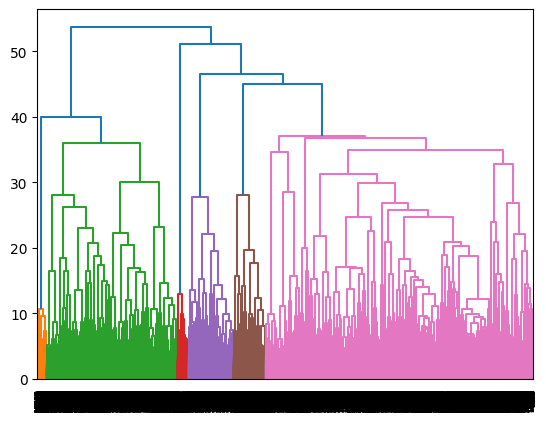

In [74]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster, linkage

def getLinkageMat(model):
    children = model.children_
    cs = np.zeros(len(children))
    N = len(model.labels_)
    for i,child in enumerate(children):
        count = 0
        for idx in child:
            count += 1 if idx < N else cs[idx - N]
        cs[i] = count
    return np.column_stack([children, model.distances_, cs])


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(np.vstack((X_train_pos, X[y==0])))
mat = getLinkageMat(model)
test = dendrogram(mat)
plt.show()

In [75]:
for n_clusters in [5,10,50,100,200,500]:
    c_sizes = []
    hierarchical_labels = fcluster(mat, n_clusters, criterion='maxclust')
    for c in np.unique(hierarchical_labels):
        cluster_indices = np.where(hierarchical_labels == c)[0]
        c_sizes.append(len(cluster_indices))
    print(np.max(np.array(c_sizes)), np.min(np.array(c_sizes)), np.mean(np.array(c_sizes)),np.std(np.array(c_sizes)))


10537 439 3913.2 3742.949820662842
7146 329 1956.6 1899.1240191203945
1514 48 391.32 306.30719482245274
1189 27 195.66 173.72939992989097
549 6 97.83 73.23695173885926
178 4 39.132 27.364549621727743


In [ ]:
# threshold = np.max(mat[:, 2])*0.7
# hierarchical_labels = fcluster(mat, threshold, criterion='distance')
n_clusters = 5
hierarchical_labels = fcluster(mat, n_clusters, criterion='maxclust')


proportion = []
unique_clusters = np.unique(hierarchical_labels)
# Total number of samples with label 1
total_y1 = np.sum(y_train == 1)
print('total positive',total_y1)
for c in unique_clusters:
    # Indices of samples in the current cluster
    cluster_indices = np.where(hierarchical_labels == c)[0]
    
    # Number of samples with label 1 in this cluster
    cluster_y1 = np.sum(y_train[cluster_indices] == 1)
    
    # Calculate A_i using the corrected formula
    A_i = len(cluster_indices) * (1 - (cluster_y1 / total_y1))
    
    proportion.append(A_i)
    print('cluster size:',len(cluster_indices),'.positives:',cluster_y1, '.random positive should be:',int(len(cluster_indices)*(total_y1/y_train.shape[0])))



total positive 105
cluster size: 1527 .positives: 21 .random positive should be: 10
cluster size: 7092 .positives: 34 .random positive should be: 47
cluster size: 317 .positives: 0 .random positive should be: 2
cluster size: 699 .positives: 0 .random positive should be: 4
cluster size: 6062 .positives: 50 .random positive should be: 40


In [69]:
neg_size = 10*total_y1 
neg_cluster = []
all_sampled_negatives = []

total_proportion = sum(proportion)
if total_proportion == 0:
    raise ValueError("Sum of proportions is zero. Check the 'proportion' calculation.")

for index, c in enumerate(unique_clusters):
    A_i = proportion[index]
    neg_i = int((A_i / total_proportion) * neg_size)
    cluster_indices = np.where(hierarchical_labels == c)[0]
    negative_indices = np.array(cluster_indices)[y_train[cluster_indices] == 0]
    # Check if there are enough negative samples to draw from
    if len(negative_indices) == 0:
        continue  
    elif neg_i > len(negative_indices):
        neg_i = len(negative_indices)  # Adjust to the maximum available
    # Sample negative indices without replacement
    sampled_indices = np.random.choice(negative_indices, size=neg_i, replace=False)
    # Store the sampled indices and the count
    all_sampled_negatives.extend(sampled_indices)
    neg_cluster.append(neg_i)

# Optional: Check if total sampled negatives match the expected size
if len(all_sampled_negatives) < neg_size:
    print(f"Warning: Only {len(all_sampled_negatives)} negatives sampled, fewer than expected {neg_size}.")


In [70]:
neg_cluster

[125, 493, 32, 71, 326]

In [ ]:
positive_indices = np.where(y_train == 1)[0]
balanced_indices = np.concatenate([positive_indices, all_sampled_negatives])
X_train_balance = X_train[balanced_indices]
y_train_balance = y_train[balanced_indices] 

In [72]:
clf = SVC(C=0.8,kernel=build_normalized_linear_kernel())
result_df.loc[len(result_df.index)] = ["pesudo_svm","norm_linear", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3884
           1       0.31      0.32      0.31        41

    accuracy                           0.99      3925
   macro avg       0.65      0.65      0.65      3925
weighted avg       0.99      0.99      0.99      3925


    Accuracy: 0.9854777070063694
    Recall: 0.9854777070063694
    Precision: 0.9856517873302125
    F1-score: 0.9855642558276593
    AUROC: 0.9211524453040617
    
Confusion Matrix:
[[3855   29]
 [  28   13]]


In [73]:
clf = SVC(C=0.8,kernel=build_normalized_poly_kernel(gamma=0.8,degree = 3))
result_df.loc[len(result_df.index)] = ["pesudo_svm","norm_poly", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3884
           1       0.37      0.41      0.39        41

    accuracy                           0.99      3925
   macro avg       0.68      0.70      0.69      3925
weighted avg       0.99      0.99      0.99      3925


    Accuracy: 0.9864968152866243
    Recall: 0.9864968152866243
    Precision: 0.9872920351859479
    F1-score: 0.9868804892642009
    AUROC: 0.921240360704328
    
Confusion Matrix:
[[3855   29]
 [  24   17]]


In [74]:
clf = SVC(C=0.8,kernel='rbf',gamma=0.8)
result_df.loc[len(result_df.index)] = ["pesudo_svm","rbf", *eval(clf, X_train_balance, y_train_balance, X_test, y_test)]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3884
           1       0.35      0.27      0.31        41

    accuracy                           0.99      3925
   macro avg       0.67      0.63      0.65      3925
weighted avg       0.99      0.99      0.99      3925


    Accuracy: 0.9872611464968153
    Recall: 0.9872611464968153
    Precision: 0.9856370518978955
    F1-score: 0.9863846929214216
    AUROC: 0.9180251689231619
    
Confusion Matrix:
[[3864   20]
 [  30   11]]


In [75]:
import gseapy as gp

In [78]:
for name in gp.get_library_name('Human'):
    if 'process' in name.lower():
        print(name)

GO_Biological_Process_2013
GO_Biological_Process_2015
GO_Biological_Process_2017
GO_Biological_Process_2017b
GO_Biological_Process_2018
GO_Biological_Process_2021
GO_Biological_Process_2023


In [79]:
keggs = gp.get_library(name='GO_Biological_Process_2023',organism='human')

In [80]:
len(keggs)

5406

In [81]:
# Get the unique list of genes
all_genes = set(gene.strip() for genes in keggs.values() for gene in genes)

# Initialize the DataFrame with 0s
kegg_df = pd.DataFrame(0, index=[list(all_genes)], columns=keggs.keys())

# Fill the DataFrame with 1s where the gene is in the pathway
for pathway, genes in keggs.items():
    kegg_df.loc[list(genes), pathway] = 1

# Optional: Sort the DataFrame by gene names
kegg_df = kegg_df.sort_index()

In [82]:
kegg_df

,'De Novo' AMP Biosynthetic Process (GO:0044208),'De Novo' Post-Translational Protein Folding (GO:0051084),2-Oxoglutarate Metabolic Process (GO:0006103),3'-UTR-mediated mRNA Destabilization (GO:0061158),3'-UTR-mediated mRNA Stabilization (GO:0070935),3'-Phosphoadenosine 5'-Phosphosulfate Metabolic Process (GO:0050427),5S Class rRNA Transcription By RNA Polymerase III (GO:0042791),7-Methylguanosine RNA Capping (GO:0009452),7-Methylguanosine Cap Hypermethylation (GO:0036261),7-Methylguanosine mRNA Capping (GO:0006370),...,Wybutosine Metabolic Process (GO:0031590),Xenobiotic Catabolic Process (GO:0042178),Xenobiotic Glucuronidation (GO:0052697),Xenobiotic Transport (GO:0042908),Xenobiotic Transport Across Blood-Brain Barrier (GO:1990962),Zinc Ion Import Into Organelle (GO:0062111),Zinc Ion Transmembrane Transport (GO:0071577),Zinc Ion Transport (GO:0006829),Zymogen Activation (GO:0031638),Zymogen Inhibition (GO:0097341)
A4GNT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AARS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AARS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AASDHPPT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZXDC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZYX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
def string_convert(gene):
    if gene in name2stringId.keys():
        return name2stringId[gene]
    elif gene in aliases2stringId.keys():
        return aliases2stringId[gene]
    else:
        return None
    
# Using list comprehension for concise and efficient processing
kegg_df.index = [string_convert(gene[0]) if isinstance(gene, tuple) else string_convert(gene) for gene in kegg_df.index]


In [84]:
kegg_df = kegg_df[kegg_df.index.notnull()]
kegg_df

,'De Novo' AMP Biosynthetic Process (GO:0044208),'De Novo' Post-Translational Protein Folding (GO:0051084),2-Oxoglutarate Metabolic Process (GO:0006103),3'-UTR-mediated mRNA Destabilization (GO:0061158),3'-UTR-mediated mRNA Stabilization (GO:0070935),3'-Phosphoadenosine 5'-Phosphosulfate Metabolic Process (GO:0050427),5S Class rRNA Transcription By RNA Polymerase III (GO:0042791),7-Methylguanosine RNA Capping (GO:0009452),7-Methylguanosine Cap Hypermethylation (GO:0036261),7-Methylguanosine mRNA Capping (GO:0006370),...,Wybutosine Metabolic Process (GO:0031590),Xenobiotic Catabolic Process (GO:0042178),Xenobiotic Glucuronidation (GO:0052697),Xenobiotic Transport (GO:0042908),Xenobiotic Transport Across Blood-Brain Barrier (GO:1990962),Zinc Ion Import Into Organelle (GO:0062111),Zinc Ion Transmembrane Transport (GO:0071577),Zinc Ion Transport (GO:0006829),Zymogen Activation (GO:0031638),Zymogen Inhibition (GO:0097341)
9606.ENSP00000236709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000386456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000261772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000244571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000278618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9606.ENSP00000364023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000374359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000294353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9606.ENSP00000324422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# from sklearn.decomposition import SparsePCA
# spca = SparsePCA(n_components=32)
# reduced_matrix = spca.fit_transform(kegg_df.values)  # Converts to dense but enforces sparse components

In [83]:
result_df

,method,kernel,accuracy,recall,precision,f1-score,auroc
0,ooc_svm,norm_linear,0.985223,0.985223,0.985223,0.985223,0.879079
1,ooc_svm,norm_poly,0.983694,0.983694,0.984081,0.983886,0.888241
2,ooc_svm,rbf,0.984713,0.984713,0.983125,0.983895,0.886916
3,random_svm,norm_linear,0.802038,0.802038,0.988104,0.880624,0.879926
4,random_svm,norm_poly,0.838981,0.838981,0.988288,0.903103,0.891085
5,random_svm,rbf,0.882548,0.882548,0.987961,0.928568,0.905309
6,pesudo_svm,norm_linear,0.792357,0.792357,0.987729,0.874600,0.889899
7,pesudo_svm,norm_poly,0.839236,0.839236,0.988290,0.903255,0.899067
8,pesudo_svm,rbf,0.890955,0.890955,0.988035,0.933374,0.902703


In [84]:
result_df.to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/results/'+disease+'.csv',index=False)